In [16]:
import collections
import cv2 as cv 
import matplotlib
%matplotlib inline
import pylab as plt
from config_reader import config_reader
import caffe
import imutils
import numpy as np
import util
import time
import math
import scipy
from scipy.ndimage.filters import gaussian_filter

In [17]:
# find connection in the specified sequence, center 29 is in the position 15
limbSeq = [[2,3], [2,6], [3,4], [4,5], [6,7], [7,8], [2,9], [9,10], \
           [10,11], [2,12], [12,13], [13,14], [2,1], [1,15], [15,17], \
           [1,16], [16,18], [3,17], [6,18]]
# the middle joints heatmap correpondence
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], [19,20], [21,22], \
          [23,24], [25,26], [27,28], [29,30], [47,48], [49,50], [53,54], [51,52], \
          [55,56], [37,38], [45,46]]
# indices of body parts dictionary
body_parts_dict = {"left_thigh": 10,
                   "right_thigh": 7,
                   "left_calf": 11,
                   "right_calf": 8,
                   "left_shoulder": 0,
                   "right_shoulder": 1,
                   "right_arm": 2,
                   "right_forearm": 3,
                   "left_arm": 4,
                   "left_forearm": 5,
                   "right_spine": 6,
                   "left_spine": 9,
                   "neck_nose": 12,
                   "nose_right_eye": 13,
                   "right_eye_right_ear": 14,
                   "nose_left_eye": 15,
                   "left_eye_left_ear": 16}
# colors of body parts
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]

In [18]:
#test_image = '../sample_image/ski.jpg'
#test_image = '../sample_image/upper.jpg'
#test_image = '../sample_image/upper2.jpg'
test_image = '../sample_image/rightleg/46_f_1_right_leg.jpg'
oriImg = cv.imread(test_image) # B,G,R order

(992, 744, 3)


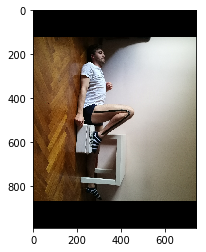

In [4]:
oriImg = cv.resize(oriImg, (744, 992))
oriImg = imutils.rotate(oriImg, -90)
print(oriImg.shape)
f = plt.imshow(oriImg[:,:,[2,1,0]])

In [5]:
param, model = config_reader()

if param['use_gpu']: 
    caffe.set_mode_gpu()
    caffe.set_device(param['GPUdeviceNumber']) # set to your device!
else:
    caffe.set_mode_cpu()
net = caffe.Net(model['deployFile'], model['caffemodel'], caffe.TEST)

heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 19))
paf_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 38))
print(paf_avg.shape)

(992, 744, 38)


In [6]:
scale = 0.5

imageToTest = cv.resize(oriImg, (0,0), fx=scale, fy=scale, interpolation=cv.INTER_CUBIC)
imageToTest_padded, pad = util.padRightDownCorner(imageToTest, model['stride'], model['padValue'])

net.blobs['data'].reshape(*(1, 3, imageToTest_padded.shape[0], imageToTest_padded.shape[1]))
net.blobs['data'].data[...] = np.transpose(np.float32(imageToTest_padded[:,:,:,np.newaxis]), (3,2,0,1))/256 - 0.5;
start_time = time.time()
output_blobs = net.forward()
print('At scale %d, The CNN took %.2f ms.' % (scale, 1000 * (time.time() - start_time)))

heatmap = np.transpose(np.squeeze(net.blobs[list(output_blobs.keys())[1]].data), (1,2,0)) # output 1 is heatmaps
heatmap = cv.resize(heatmap, (0,0), fx=model['stride'], fy=model['stride'], interpolation=cv.INTER_CUBIC)
heatmap = heatmap[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
heatmap = cv.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv.INTER_CUBIC)

paf = np.transpose(np.squeeze(net.blobs[list(output_blobs.keys())[0]].data), (1,2,0)) # output 0 is PAFs
paf = cv.resize(paf, (0,0), fx=model['stride'], fy=model['stride'], interpolation=cv.INTER_CUBIC)
paf = paf[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
paf = cv.resize(paf, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv.INTER_CUBIC)

heatmap_avg = heatmap_avg + heatmap
paf_avg = paf_avg + paf
print(paf_avg.shape)

At scale 0, The CNN took 310.81 ms.
(992, 744, 38)


In [7]:
all_peaks = []
peak_counter = 0

for part in range(19-1):
    map_ori = heatmap_avg[:,:,part]
    mapp = gaussian_filter(map_ori, sigma=3)
    
    map_left = np.zeros(mapp.shape)
    map_left[1:,:] = mapp[:-1,:]
    map_right = np.zeros(mapp.shape)
    map_right[:-1,:] = mapp[1:,:]
    map_up = np.zeros(mapp.shape)
    map_up[:,1:] = mapp[:,:-1]
    map_down = np.zeros(mapp.shape)
    map_down[:,:-1] = mapp[:,1:]
    
    peaks_binary = np.logical_and.reduce((mapp>=map_left, mapp>=map_right, mapp>=map_up, mapp>=map_down, mapp > param['thre1']))
    peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0])) # note reverse
    peaks_with_score = [x + (map_ori[x[1],x[0]],) for x in peaks]
    id = range(peak_counter, peak_counter + len(peaks))
    peaks_with_score_and_id = [peaks_with_score[i] + (id[i],) for i in range(len(id))]

    all_peaks.append(peaks_with_score_and_id)
    peak_counter += len(peaks)

In [8]:
connection_all = []
special_k = []
mid_num = 10

for k in range(len(mapIdx)):
    score_mid = paf_avg[:,:,[x-19 for x in mapIdx[k]]]
    candA = all_peaks[limbSeq[k][0]-1]
    candB = all_peaks[limbSeq[k][1]-1]
    nA = len(candA)
    nB = len(candB)
    indexA, indexB = limbSeq[k]
    if(nA != 0 and nB != 0):
        connection_candidate = []
        for i in range(nA):
            for j in range(nB):
                vec = np.subtract(candB[j][:2], candA[i][:2])
                norm = math.sqrt(vec[0]*vec[0] + vec[1]*vec[1])
                vec = np.divide(vec, norm)
                
                startend = list(zip(np.linspace(candA[i][0], candB[j][0], num=mid_num), \
                                    np.linspace(candA[i][1], candB[j][1], num=mid_num)))
                
                vec_x = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 0] \
                                  for I in range(len(startend))])
                vec_y = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 1] \
                                  for I in range(len(startend))])

                score_midpts = np.multiply(vec_x, vec[0]) + np.multiply(vec_y, vec[1])
                try:
                    score_with_dist_prior = sum(score_midpts)/len(score_midpts) + min(0.5*oriImg.shape[0]/norm-1, 0)
                except ZeroDivisionError:
                    continue
                criterion1 = len(np.nonzero(score_midpts > param['thre2'])[0]) > 0.8 * len(score_midpts)
                criterion2 = score_with_dist_prior > 0
                if criterion1 and criterion2:
                    connection_candidate.append([i, j, score_with_dist_prior, score_with_dist_prior+candA[i][2]+candB[j][2]])

        connection_candidate = sorted(connection_candidate, key=lambda x: x[2], reverse=True)
        connection = np.zeros((0,5))
        for c in range(len(connection_candidate)):
            i,j,s = connection_candidate[c][0:3]
            if(i not in connection[:,3] and j not in connection[:,4]):
                connection = np.vstack([connection, [candA[i][3], candB[j][3], s, i, j]])
                if(len(connection) >= min(nA, nB)):
                    break

        connection_all.append(connection)
    else:
        special_k.append(k)
        connection_all.append([])

In [9]:
# last number in each row is the total parts number of that person
# the second last number in each row is the score of the overall configuration
subset = -1 * np.ones((0, 20))
candidate = np.array([item for sublist in all_peaks for item in sublist])

for k in range(len(mapIdx)):
    if k not in special_k:
        partAs = connection_all[k][:,0]
        partBs = connection_all[k][:,1]
        indexA, indexB = np.array(limbSeq[k]) - 1

        for i in range(len(connection_all[k])): #= 1:size(temp,1)
            found = 0
            subset_idx = [-1, -1]
            for j in range(len(subset)): #1:size(subset,1):
                if subset[j][indexA] == partAs[i] or subset[j][indexB] == partBs[i]:
                    subset_idx[found] = j
                    found += 1
            
            if found == 1:
                j = subset_idx[0]
                if(subset[j][indexB] != partBs[i]):
                    subset[j][indexB] = partBs[i]
                    subset[j][-1] += 1
                    subset[j][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]
            elif found == 2: # if found 2 and disjoint, merge them
                j1, j2 = subset_idx
                membership = ((subset[j1]>=0).astype(int) + (subset[j2]>=0).astype(int))[:-2]
                if len(np.nonzero(membership == 2)[0]) == 0: #merge
                    subset[j1][:-2] += (subset[j2][:-2] + 1)
                    subset[j1][-2:] += subset[j2][-2:]
                    subset[j1][-2] += connection_all[k][i][2]
                    subset = np.delete(subset, j2, 0)
                else: # as like found == 1
                    subset[j1][indexB] = partBs[i]
                    subset[j1][-1] += 1
                    subset[j1][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]

            # if find no partA in the subset, create a new subset
            elif not found and k < 17:
                row = -1 * np.ones(20)
                row[indexA] = partAs[i]
                row[indexB] = partBs[i]
                row[-1] = 2
                row[-2] = sum(candidate[connection_all[k][i,:2].astype(int), 2]) + connection_all[k][i][2]
                subset = np.vstack([subset, row])

In [10]:
deleteIdx = [];
for i in range(len(subset)):
    if subset[i][-1] < 4 or subset[i][-2]/subset[i][-1] < 0.4:
        deleteIdx.append(i)
subset = np.delete(subset, deleteIdx, axis=0)

In [11]:
def define_points(points_list):
    center_point = [item for item, count in collections.Counter(points_list).items() if count > 1][0]
    other_points = [item for item in points_list if item != center_point]
    return center_point, other_points

In [12]:
def calc_dist(point_1, point_2):
    dist = math.sqrt((point_1[1] - point_2[1]) ** 2 + (point_1[0] - point_2[0]) ** 2)
    return dist

In [13]:
def calc_angle(a, b, c):
    expr = (a ** 2 + b ** 2 - c ** 2)/(2 * a * b)
    ang = math.degrees(math.acos(expr))
    return ang

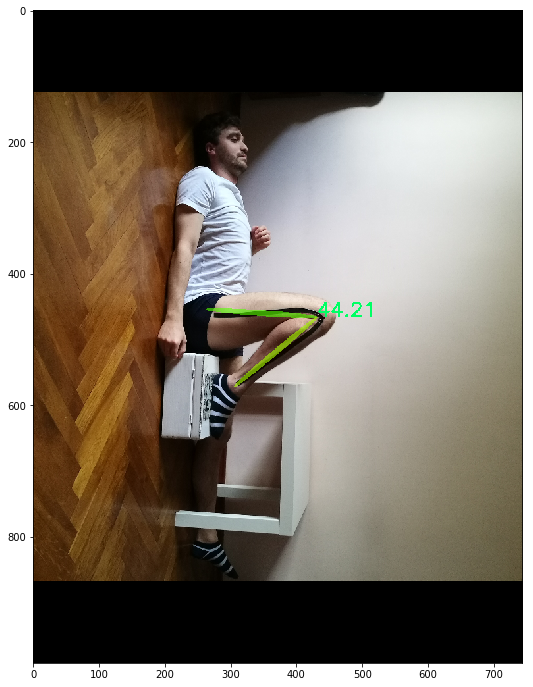

In [14]:
stickwidth = 4
canvas = cv.imread(test_image)
canvas = cv.resize(canvas, (744, 992))
canvas = imutils.rotate(canvas, -90)

#body_parts = ["left_forearm", "right_forearm", "left_arm", "right_arm", "left_thigh", "right_thigh", "left_calf", "right_calf"]
body_parts = ["right_thigh", "right_calf"]
#body_parts = ["left_thigh", "left_calf"]
#body_parts_pairs = [("left_forearm", "left_arm"), ("right_forearm", "right_arm"), ("left_thigh", "left_calf"), ("right_thigh", "right_calf")]
body_parts_pairs = [("right_thigh", "right_calf")]
#body_parts_pairs = [("left_thigh", "left_calf")]
pts_list = []
for person, n in enumerate(subset):#[4:5]):
    angles_dict = {}
    pts_dict = {}
    for part in body_parts:
        cur_canvas = canvas.copy()

        index_part = n[np.array(limbSeq[body_parts_dict[part]]) - 1]
        if -1 in index_part:
            continue
        Y = candidate[index_part.astype(int), 0]#[0], candidate[index_part.astype(int), 1][0])
        X = candidate[index_part.astype(int), 1]#[1], candidate[index_part.astype(int), 1][1])
        mX = np.mean(X)
        mY = np.mean(Y)
        length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
        angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
        polygon = cv.ellipse2Poly((int(mY), int(mX)), (int(length/2), stickwidth), int(angle), 0, 360, 1)
        cv.fillConvexPoly(cur_canvas, polygon, colors[body_parts_dict[part]])
        canvas = cv.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)
        pts_dict[part] = [(Y[0], X[0]), (Y[1], X[1])]
    pts_list.append([person, pts_dict])
    
    for pair in body_parts_pairs:
        try:
            points = pts_dict[pair[0]] + pts_dict[pair[1]]
            center, other = define_points(points)
            center_dist = calc_dist(other[0], other[1])
            other_dist_1 = calc_dist(center, other[0])
            other_dist_2 = calc_dist(center, other[1])
            angle = calc_angle(other_dist_1, other_dist_2, center_dist)
            canvas = cv.putText(canvas, "{:.2f}".format(angle), (int(center[0]), int(center[1])), fontFace=cv.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(100,255,0), thickness=2, lineType=1)
        except KeyError:
            continue
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)
plt.imshow(canvas[:, :, [2, 1, 0]])

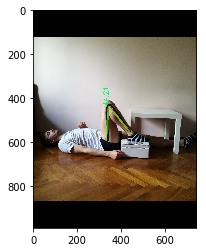

In [15]:
canvas = imutils.rotate(canvas, 90)
plt.imshow(canvas[:, :, [2, 1, 0]])